# Import Libaray

In [1]:
# Import libaray
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import cv2
import random
from PIL import Image
from skimage.transform import AffineTransform, warp, rotate

# Library Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG19, Xception, DenseNet201
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

# Data Preparation

## Data Loading

In [2]:
# Import data dari gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path ke folder dataset di Google Drive
data_path = '/content/drive/MyDrive/[CC25-CF115] Kuliner Kita Capstone Project/Dataset/unprocessed_dataset'

# Melihat isi direktori
os.listdir(data_path)

['ayam_pop',
 'gulai_tunjang',
 'dendeng_batokok',
 'telur_balado',
 'daging_rendang',
 'gulai_ikan',
 'telur_dadar',
 'soto',
 'rawon',
 'pempek',
 'nasi_goreng',
 'gudeg',
 'gado_gado',
 'bebek_betutu',
 'bakso',
 'tahu_gejrot',
 'kue_lumpur',
 'kue_dadar_gulung',
 'kue_klepon',
 'kerak_telor',
 'ayam_goreng_bumbu_lengkuas',
 'kue_lemper',
 'onde_onde',
 'ayam_bakar',
 'tempe_mendoan',
 'sate_kambing',
 'kue_serabi',
 'martabak_telur',
 'bubur_ayam',
 'lumpia']

In [ ]:
# Cek kelas yang tersedia
classes  = os.listdir(data_path)
print('Kelas yang tersedia:', classes)

# Hitung jumlah gambar per kelas
for class_name in classes:
  class_path = os.path.join(data_path, class_name)
  num_images = len(os.listdir(class_path))
  print(f'{class_name}: {num_images} gambar')

Kelas yang tersedia: ['ayam_pop', 'gulai_tunjang', 'dendeng_batokok', 'telur_balado', 'daging_rendang', 'gulai_ikan', 'telur_dadar', 'soto', 'rawon', 'pempek', 'nasi_goreng', 'gudeg', 'gado_gado', 'bebek_betutu', 'bakso', 'tahu_gejrot', 'kue_lumpur', 'kue_dadar_gulung', 'kue_klepon', 'kerak_telor', 'ayam_goreng_bumbu_lengkuas', 'kue_lemper', 'onde_onde', 'ayam_bakar', 'tempe_mendoan', 'sate_kambing', 'kue_serabi', 'martabak_telur', 'bubur_ayam', 'lumpia']
ayam_pop: 489 gambar
gulai_tunjang: 519 gambar
dendeng_batokok: 295 gambar
telur_balado: 520 gambar
daging_rendang: 504 gambar
gulai_ikan: 307 gambar
telur_dadar: 248 gambar
soto: 500 gambar
rawon: 339 gambar
pempek: 409 gambar
nasi_goreng: 500 gambar
gudeg: 295 gambar
gado_gado: 376 gambar
bebek_betutu: 335 gambar
bakso: 445 gambar
tahu_gejrot: 160 gambar
kue_lumpur: 170 gambar
kue_dadar_gulung: 165 gambar
kue_klepon: 133 gambar
kerak_telor: 152 gambar
ayam_goreng_bumbu_lengkuas: 438 gambar
kue_lemper: 120 gambar
onde_onde: 100 gamba

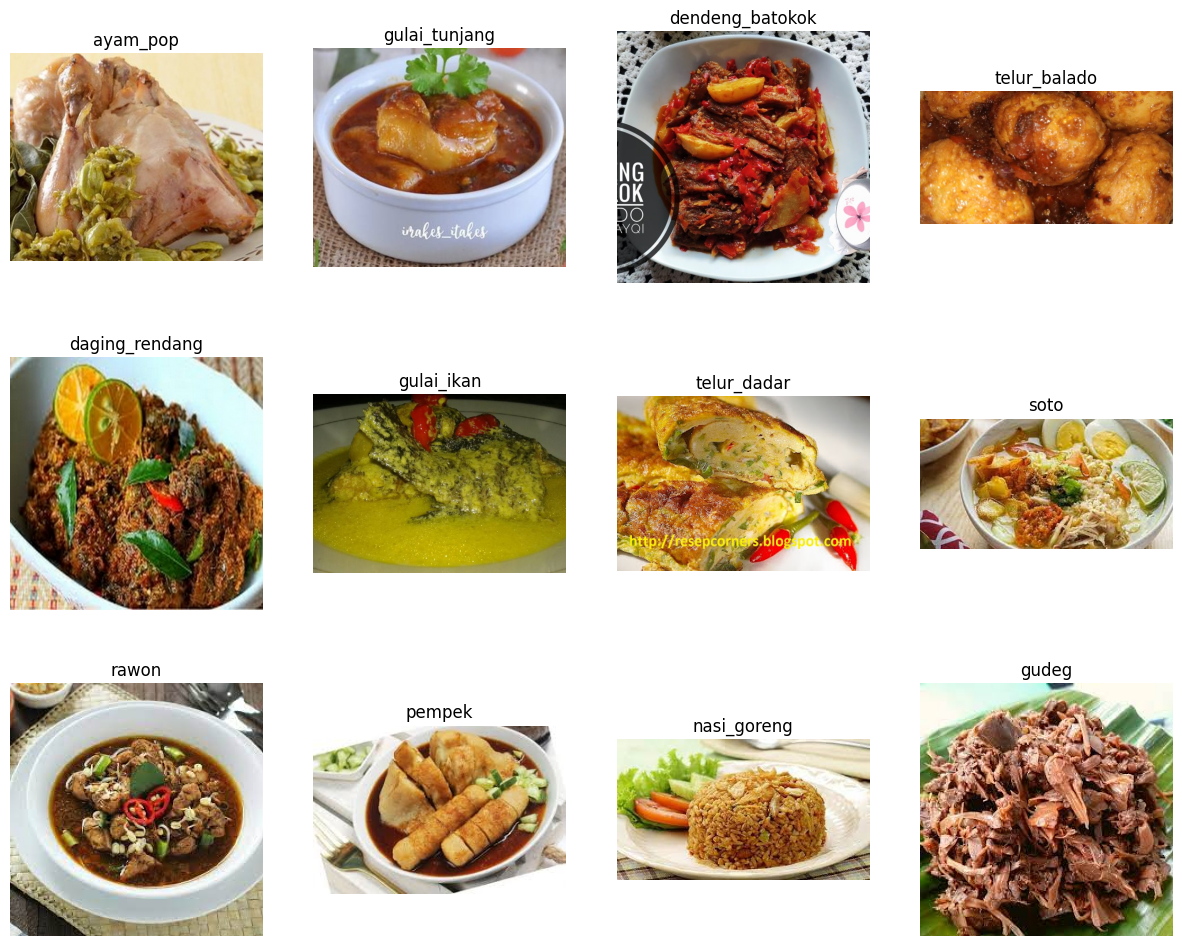

In [ ]:
# Visualisasi contoh gambar
plt.figure(figsize=(15, 12))
for i, class_name in enumerate(classes[:12]):  # Menampilkan 12 contoh kelas pertama
    class_path = os.path.join(data_path, class_name)
    img_name = os.listdir(class_path)[0]
    img_path = os.path.join(class_path, img_name)

    img = Image.open(img_path)
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
plt.show()

## Split Data

### Split data 80/20

In [ ]:
def split_balanced_dataset(input_dir, output_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, min_val_test=20):
    """
    Membagi dataset ke dalam folder train, val, dan test dengan rasio seimbang untuk setiap kelas.
    Akan menjaga agar minimal jumlah val/test tetap masuk akal untuk kelas kecil.
    """
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Rasio total harus 1.0"

    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = [os.path.join(class_path, img) for img in os.listdir(class_path)
                  if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

        random.shuffle(images)
        total = len(images)

        # Hitung jumlah berdasarkan rasio
        train_len = int(train_ratio * total)
        val_len = int(val_ratio * total)
        test_len = total - train_len - val_len

        # Untuk kelas kecil, pastikan minimal val/test sesuai min_val_test (jika memungkinkan)
        if total >= (min_val_test * 2 + 10):  # Cukup besar untuk penuhi syarat
            val_len = max(val_len, min_val_test)
            test_len = max(test_len, min_val_test)
            train_len = total - val_len - test_len
        elif total < 30:  # Kasus ekstrem
            # Train semua, skip val/test
            train_len = total
            val_len = 0
            test_len = 0

        split_data = {
            'train': images[:train_len],
            'val': images[train_len:train_len + val_len],
            'test': images[train_len + val_len:]
        }

        for split, files in split_data.items():
            split_class_dir = os.path.join(output_dir, split, class_name)
            os.makedirs(split_class_dir, exist_ok=True)
            for file in files:
                shutil.copy(file, os.path.join(split_class_dir, os.path.basename(file)))

        print(f"Kelas '{class_name}' | Total: {total} | Train: {train_len} | Val: {val_len} | Test: {test_len}")

    print("\n✅ Dataset berhasil di-split dengan rasio 80:10:10 dan penyesuaian untuk kelas kecil.")

# Jalankan fungsi split dengan path kamu
split_balanced_dataset(
    input_dir='/content/drive/MyDrive/[CC25-CF115] Kuliner Kita Capstone Project/Dataset/unprocessed_dataset',
    output_dir='/content/drive/MyDrive/Capstone Project/Dataset/dataset-split-80-10-10',
    train_ratio=0.8,
    val_ratio=0.1,
    test_ratio=0.1,
    min_val_test=20
)

Kelas 'ayam_pop' | Total: 454 | Train: 363 | Val: 45 | Test: 46
Kelas 'gulai_tunjang' | Total: 495 | Train: 396 | Val: 49 | Test: 50
Kelas 'dendeng_batokok' | Total: 269 | Train: 215 | Val: 26 | Test: 28
Kelas 'telur_balado' | Total: 489 | Train: 391 | Val: 48 | Test: 50
Kelas 'daging_rendang' | Total: 504 | Train: 403 | Val: 50 | Test: 51
Kelas 'gulai_ikan' | Total: 272 | Train: 217 | Val: 27 | Test: 28
Kelas 'telur_dadar' | Total: 240 | Train: 192 | Val: 24 | Test: 24
Kelas 'soto' | Total: 500 | Train: 400 | Val: 50 | Test: 50
Kelas 'rawon' | Total: 339 | Train: 271 | Val: 33 | Test: 35
Kelas 'pempek' | Total: 409 | Train: 327 | Val: 40 | Test: 42
Kelas 'nasi_goreng' | Total: 500 | Train: 400 | Val: 50 | Test: 50
Kelas 'gudeg' | Total: 295 | Train: 236 | Val: 29 | Test: 30
Kelas 'gado_gado' | Total: 376 | Train: 300 | Val: 37 | Test: 39
Kelas 'bebek_betutu' | Total: 335 | Train: 268 | Val: 33 | Test: 34
Kelas 'bakso' | Total: 445 | Train: 356 | Val: 44 | Test: 45
Kelas 'tahu_gejrot' 

In [ ]:
# Set path untuk nanti digunakan saat training
base_dir_80_20 = '/content/drive/MyDrive/Capstone Project/Dataset/dataset-split-80-10-10'
train_dir_80_20 = os.path.join(base_dir_80_20, 'train')
test_dir_80_20 = os.path.join(base_dir_80_20, 'test')
val_dir_80_20 = os.path.join(base_dir_80_20, 'val')

### Split data 70/15/15

In [ ]:
def split_balanced_dataset(input_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Membagi dataset ke dalam folder train, val, dan test dengan rasio seimbang untuk setiap kelas.
    """
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Rasio total harus 1.0"

    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = [os.path.join(class_path, img) for img in os.listdir(class_path)
                  if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

        random.shuffle(images)

        total = len(images)
        train_len = int(train_ratio * total)
        val_len = int(val_ratio * total)
        test_len = total - train_len - val_len

        split_data = {
            'train': images[:train_len],
            'val': images[train_len:train_len + val_len],
            'test': images[train_len + val_len:]
        }

        for split, files in split_data.items():
            split_class_dir = os.path.join(output_dir, split, class_name)
            os.makedirs(split_class_dir, exist_ok=True)
            for file in files:
                shutil.copy(file, os.path.join(split_class_dir, os.path.basename(file)))

        print(f"Kelas '{class_name}' | Total: {total} | Train: {train_len} | Val: {val_len} | Test: {test_len}")

    print("\n✅ Dataset berhasil di-split dengan rasio 70:15:15.")

# Jalankan fungsi split dengan path project kamu
split_balanced_dataset(
    input_dir='/content/drive/MyDrive/[CC25-CF115] Kuliner Kita Capstone Project/Dataset/unprocessed_dataset',
    output_dir='/content/drive/MyDrive/Capstone Project/Dataset/dataset-split-70-15-15',
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15
)

Kelas 'ayam_pop' | Total: 454 | Train: 317 | Val: 68 | Test: 69
Kelas 'gulai_tunjang' | Total: 495 | Train: 346 | Val: 74 | Test: 75
Kelas 'dendeng_batokok' | Total: 269 | Train: 188 | Val: 40 | Test: 41
Kelas 'telur_balado' | Total: 489 | Train: 342 | Val: 73 | Test: 74
Kelas 'daging_rendang' | Total: 504 | Train: 352 | Val: 75 | Test: 77
Kelas 'gulai_ikan' | Total: 272 | Train: 190 | Val: 40 | Test: 42
Kelas 'telur_dadar' | Total: 240 | Train: 168 | Val: 36 | Test: 36
Kelas 'soto' | Total: 500 | Train: 350 | Val: 75 | Test: 75
Kelas 'rawon' | Total: 339 | Train: 237 | Val: 50 | Test: 52
Kelas 'pempek' | Total: 409 | Train: 286 | Val: 61 | Test: 62
Kelas 'nasi_goreng' | Total: 500 | Train: 350 | Val: 75 | Test: 75
Kelas 'gudeg' | Total: 295 | Train: 206 | Val: 44 | Test: 45
Kelas 'gado_gado' | Total: 376 | Train: 263 | Val: 56 | Test: 57
Kelas 'bebek_betutu' | Total: 335 | Train: 234 | Val: 50 | Test: 51
Kelas 'bakso' | Total: 445 | Train: 311 | Val: 66 | Test: 68
Kelas 'tahu_gejrot' 

In [ ]:
# Set path untuk nanti digunakan saat training
base_dir_70_30 = '/content/drive/MyDrive/Capstone Project/Dataset/dataset-split-70-15-15'
train_dir_70_30 = os.path.join(base_dir_70_30, 'train')
test_dir_70_30 = os.path.join(base_dir_70_30, 'test')
val_dir_70_30 = os.path.join(base_dir_70_30, 'val')

### split K-Fold

In [ ]:
from sklearn.model_selection import StratifiedKFold

def stratified_kfold_split_dataset(input_dir, output_dir, n_splits=5, random_state=42):
    """
    Membagi dataset ke dalam K fold stratified untuk cross validation,
    menyimpan file dalam folder fold_{i}/train dan fold_{i}/val.
    """
    # 1. List semua gambar dan label
    data = []
    labels = []
    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        images = [os.path.join(class_path, img) for img in os.listdir(class_path)
                  if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
        for img_path in images:
            data.append(img_path)
            labels.append(class_name)

    data = np.array(data)
    labels = np.array(labels)

    # 2. Buat stratified KFold splitter
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # 3. Loop tiap fold dan simpan file ke folder sesuai
    for fold, (train_idx, val_idx) in enumerate(skf.split(data, labels)):
        print(f"Fold {fold + 1}/{n_splits}")

        fold_train_dir = os.path.join(output_dir, f'fold_{fold+1}', 'train')
        fold_val_dir = os.path.join(output_dir, f'fold_{fold+1}', 'val')

        # Bersihkan folder jika sudah ada supaya hasilnya fresh
        if os.path.exists(fold_train_dir):
            shutil.rmtree(fold_train_dir)
        if os.path.exists(fold_val_dir):
            shutil.rmtree(fold_val_dir)

        os.makedirs(fold_train_dir, exist_ok=True)
        os.makedirs(fold_val_dir, exist_ok=True)

        # Copy file train
        for idx in train_idx:
            img_path = data[idx]
            class_name = labels[idx]
            dest_dir = os.path.join(fold_train_dir, class_name)
            os.makedirs(dest_dir, exist_ok=True)
            shutil.copy(img_path, os.path.join(dest_dir, os.path.basename(img_path)))

        # Copy file val
        for idx in val_idx:
            img_path = data[idx]
            class_name = labels[idx]
            dest_dir = os.path.join(fold_val_dir, class_name)
            os.makedirs(dest_dir, exist_ok=True)
            shutil.copy(img_path, os.path.join(dest_dir, os.path.basename(img_path)))

        print(f"Fold {fold+1}: Train {len(train_idx)} images, Val {len(val_idx)} images\n")

    print(f"✅ Stratified K-Fold cross validation dataset sudah tersimpan di:\n{output_dir}")

# Panggil fungsi
stratified_kfold_split_dataset(
    input_dir='/content/drive/MyDrive/[CC25-CF115] Kuliner Kita Capstone Project/Dataset/unprocessed_dataset',
    output_dir='/content/drive/MyDrive/Capstone Project/dataset-kfold',
    n_splits=5,
    random_state=42
)

Fold 1/5
Fold 1: Train 7037 images, Val 1760 images

Fold 2/5
Fold 2: Train 7037 images, Val 1760 images

Fold 3/5
Fold 3: Train 7038 images, Val 1759 images

Fold 4/5
Fold 4: Train 7038 images, Val 1759 images

Fold 5/5
Fold 5: Train 7038 images, Val 1759 images

✅ Stratified K-Fold cross validation dataset sudah tersimpan di:
/content/drive/MyDrive/Capstone Project/dataset-kfold


### Persebaran data Train, Test, and validation


📊 Distribusi data pada folder TRAIN:
ayam_pop: 363
gulai_tunjang: 396
dendeng_batokok: 215
telur_balado: 391
daging_rendang: 403
gulai_ikan: 217
telur_dadar: 192
soto: 400
rawon: 271
pempek: 327
nasi_goreng: 400
gudeg: 236
gado_gado: 300
bebek_betutu: 268
bakso: 356
tahu_gejrot: 120
kue_lumpur: 130
kue_dadar_gulung: 125
kue_klepon: 91
kerak_telor: 112
ayam_goreng_bumbu_lengkuas: 345
kue_lemper: 53
onde_onde: 60
ayam_bakar: 89
tempe_mendoan: 85
sate_kambing: 90
kue_serabi: 249
martabak_telur: 153
bubur_ayam: 226
lumpia: 240


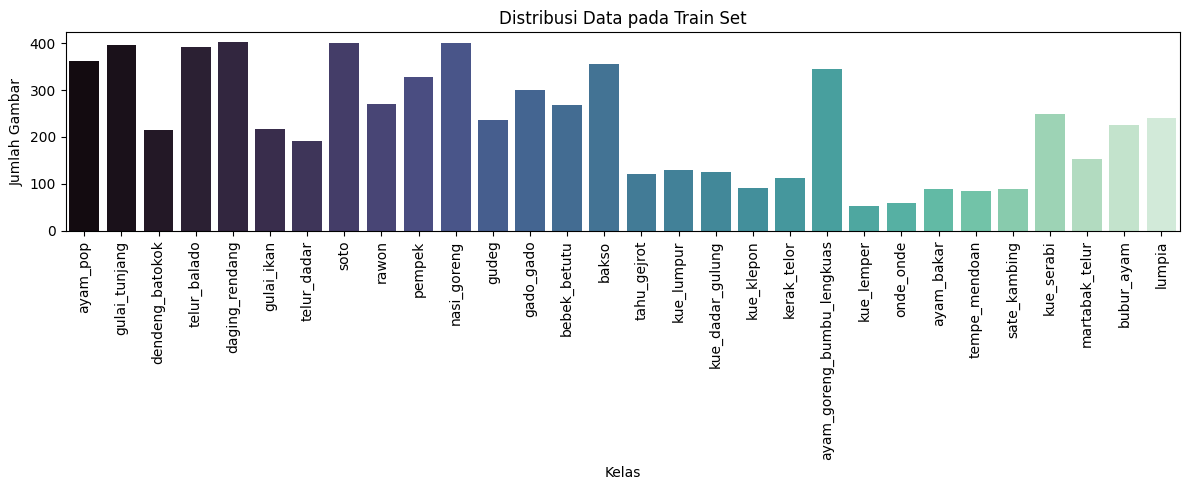


📊 Distribusi data pada folder VAL:
ayam_pop: 45
gulai_tunjang: 49
dendeng_batokok: 26
telur_balado: 48
daging_rendang: 50
gulai_ikan: 27
telur_dadar: 24
soto: 50
rawon: 33
pempek: 40
nasi_goreng: 50
gudeg: 29
gado_gado: 37
bebek_betutu: 33
bakso: 44
tahu_gejrot: 20
kue_lumpur: 20
kue_dadar_gulung: 20
kue_klepon: 20
kerak_telor: 20
ayam_goreng_bumbu_lengkuas: 43
kue_lemper: 20
onde_onde: 20
ayam_bakar: 20
tempe_mendoan: 20
sate_kambing: 20
kue_serabi: 31
martabak_telur: 20
bubur_ayam: 28
lumpia: 30


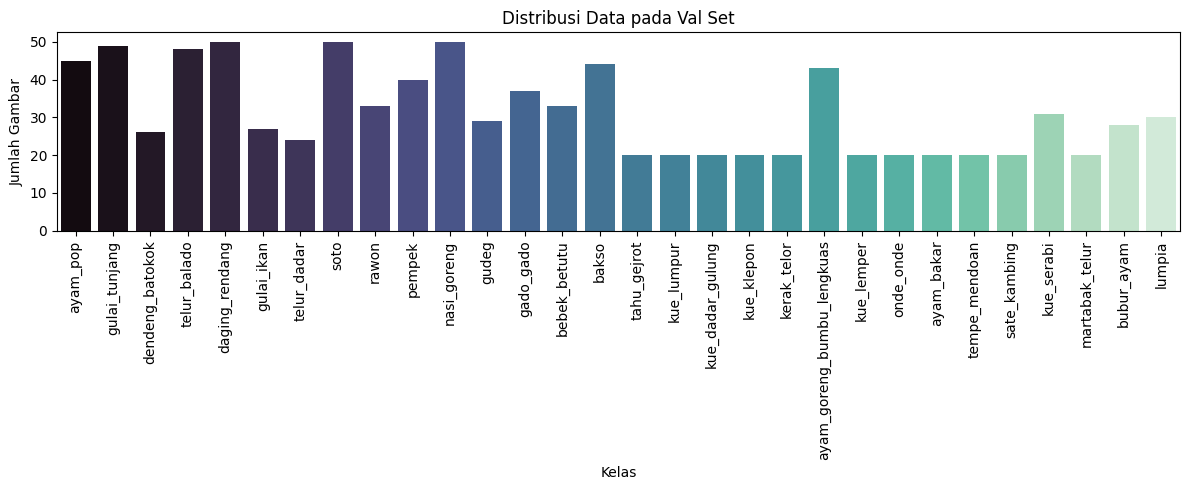


📊 Distribusi data pada folder TEST:
ayam_pop: 46
gulai_tunjang: 50
dendeng_batokok: 28
telur_balado: 50
daging_rendang: 51
gulai_ikan: 28
telur_dadar: 24
soto: 50
rawon: 35
pempek: 42
nasi_goreng: 50
gudeg: 30
gado_gado: 39
bebek_betutu: 34
bakso: 45
tahu_gejrot: 20
kue_lumpur: 20
kue_dadar_gulung: 20
kue_klepon: 20
kerak_telor: 20
ayam_goreng_bumbu_lengkuas: 44
kue_lemper: 20
onde_onde: 20
ayam_bakar: 20
tempe_mendoan: 20
sate_kambing: 20
kue_serabi: 32
martabak_telur: 20
bubur_ayam: 29
lumpia: 30


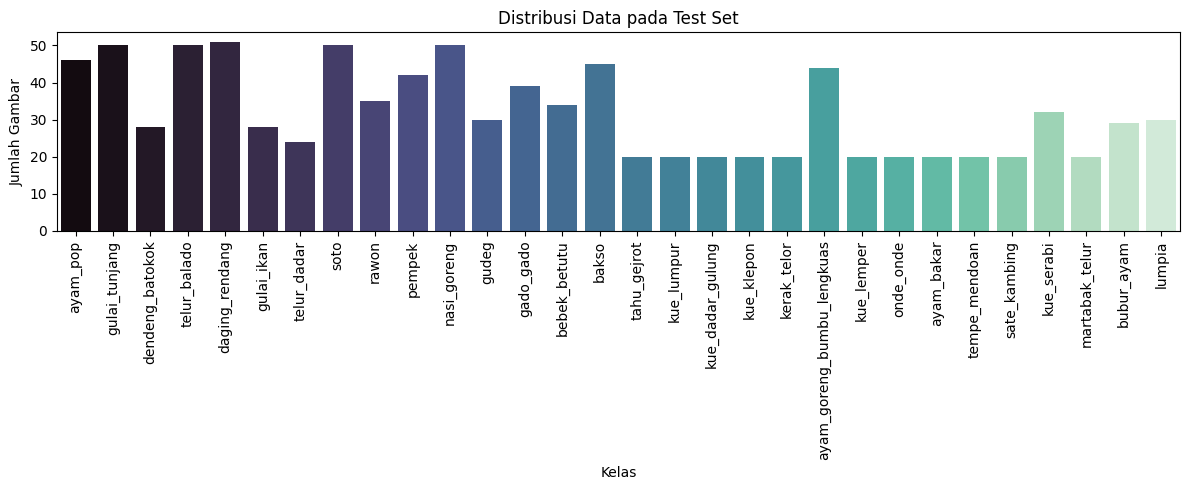

In [ ]:
def plot_class_distribution(dataset_dir, split_name):
    class_counts = {}

    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path)
                         if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            class_counts[class_name] = count

    print(f"\n📊 Distribusi data pada folder {split_name.upper()}:")
    for cls, count in class_counts.items():
        print(f"{cls}: {count}")

    # Visualisasi
    plt.figure(figsize=(12, 5))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='mako')
    plt.title(f'Distribusi Data pada {split_name.capitalize()} Set')
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Gambar')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


# Path ke direktori setelah split
train_dir = '/content/drive/MyDrive/Capstone Project/Dataset/dataset-split-80-10-10/train'
val_dir = '/content/drive/MyDrive/Capstone Project/Dataset/dataset-split-80-10-10/val'
test_dir = '/content/drive/MyDrive/Capstone Project/Dataset/dataset-split-80-10-10/test'

# Panggil fungsi untuk masing-masing set
plot_class_distribution(train_dir, 'train')
plot_class_distribution(val_dir, 'val')
plot_class_distribution(test_dir, 'test')

# Percobaan 1: split 80, DenseNet-201, adam, dan lr 0,001

In [ ]:
# Set path untuk nanti digunakan saat training
base_dir_80_20 = '/content/drive/MyDrive/Capstone Project/Dataset/dataset-split-80-10-10'
train_dir_80_20 = os.path.join(base_dir_80_20, 'train')
test_dir_80_20 = os.path.join(base_dir_80_20, 'test')
val_dir_80_20 = os.path.join(base_dir_80_20, 'val')

## Data Augmentasi

In [ ]:
# function untuk augmentasi data
def to_uint8(img):
    img = np.clip(img * 255, 0, 255).astype(np.uint8)
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

def sheared(img):
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    transform = AffineTransform(shear=0.2)
    sheared_img = warp(img, transform, mode="wrap")
    return to_uint8(sheared_img)

def warp_shift(img):
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    transform = AffineTransform(translation=(0, 40))
    warped_img = warp(img, transform, mode="wrap")
    return to_uint8(warped_img)

def blur_image(img):
    img = cv2.resize(img, (224, 224))
    blur_img = cv2.GaussianBlur(img, (9, 9), 0)
    return blur_img

def add_brightness(img):
    img = cv2.resize(img, (224, 224))
    bright_img = cv2.convertScaleAbs(img, alpha=1.5, beta=30)
    return bright_img

def clockwise_rotation(img):
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    angle = random.randint(5, 45)
    rotated = rotate(img, -angle, mode='wrap')
    return to_uint8(rotated)

def anticlockwise_rotation(img):
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    angle = random.randint(5, 45)
    rotated = rotate(img, angle, mode='wrap')
    return to_uint8(rotated)

In [ ]:
# Transformasi yang digunakan
transformation = {
    'rotate_anticlockwise': anticlockwise_rotation,
    'rotate_clockwise': clockwise_rotation,
    'warp_shift': warp_shift,
    'blur_image': blur_image,
    'add_brightness': add_brightness,
    'sheared': sheared
}

# Path input hanya untuk training
train_dir_80 = '/content/drive/MyDrive/Capstone Project/Dataset/dataset-split-80-10-10/train'

# Path output augmentasi
augmented_path_80 = '/content/drive/MyDrive/Capstone Project/Dataset/dataset-split-80-10-10/augmentasi-train'


# Target total gambar per kelas setelah augmentasi
target_total_per_class = 500

# Loop setiap kelas di folder train
for class_name in os.listdir(train_dir_80):
    class_path = os.path.join(train_dir_80, class_name)

    if not os.path.isdir(class_path):
        continue

    # Buat folder kelas di output folder augmentasi
    class_augmented_path = os.path.join(augmented_path_80, class_name)
    os.makedirs(class_augmented_path, exist_ok=True)

    # Ambil semua gambar dari folder asli
    images = [
        os.path.join(class_path, img) for img in os.listdir(class_path)
        if img.lower().endswith(('.jpg', '.png', '.jpeg'))
    ]

    # Salin gambar asli ke folder augmentasi
    for img in images:
        shutil.copy(img, os.path.join(class_augmented_path, os.path.basename(img)))

    current_count = len(images)
    num_to_generate = target_total_per_class - current_count

    print(f"{class_name} | Original: {current_count} | Augmenting: {num_to_generate}")

    if num_to_generate <= 0:
        print(f"Class '{class_name}' already has enough images. Skipping augmentation.")
        continue

    i = 1
    while i <= num_to_generate:
        image_path = random.choice(images)
        img_cv = cv2.imread(image_path)

        if img_cv is None:
            print(f"Failed to read image: {image_path}, skipping...")
            continue

        transformation_name, transformation_function = random.choice(list(transformation.items()))
        try:
            augmented_image = transformation_function(img_cv)
            filename = f"{class_name}_{transformation_name}_{i}.jpg"
            save_path = os.path.join(class_augmented_path, filename)
            cv2.imwrite(save_path, augmented_image)
            i += 1
        except Exception as e:
            print(f"Error during augmentation: {e}")

ayam_pop | Original: 363 | Augmenting: 137
gulai_tunjang | Original: 396 | Augmenting: 104
dendeng_batokok | Original: 215 | Augmenting: 285
telur_balado | Original: 391 | Augmenting: 109
daging_rendang | Original: 403 | Augmenting: 97
gulai_ikan | Original: 217 | Augmenting: 283
telur_dadar | Original: 192 | Augmenting: 308
soto | Original: 400 | Augmenting: 100
rawon | Original: 271 | Augmenting: 229
pempek | Original: 327 | Augmenting: 173
nasi_goreng | Original: 400 | Augmenting: 100
gudeg | Original: 236 | Augmenting: 264
gado_gado | Original: 300 | Augmenting: 200
bebek_betutu | Original: 268 | Augmenting: 232
bakso | Original: 356 | Augmenting: 144
tahu_gejrot | Original: 120 | Augmenting: 380
kue_lumpur | Original: 130 | Augmenting: 370
kue_dadar_gulung | Original: 125 | Augmenting: 375
kue_klepon | Original: 91 | Augmenting: 409
kerak_telor | Original: 112 | Augmenting: 388
ayam_goreng_bumbu_lengkuas | Original: 345 | Augmenting: 155
kue_lemper | Original: 53 | Augmenting: 447

Class Distribution
ayam_pop: 500
gulai_tunjang: 500
dendeng_batokok: 500
telur_balado: 500
daging_rendang: 500
gulai_ikan: 500
telur_dadar: 500
soto: 500
rawon: 500
pempek: 500
nasi_goreng: 500
gudeg: 500
gado_gado: 500
bebek_betutu: 500
bakso: 500
tahu_gejrot: 500
kue_lumpur: 500
kue_dadar_gulung: 500
kue_klepon: 500
kerak_telor: 500
ayam_goreng_bumbu_lengkuas: 500
kue_lemper: 500
onde_onde: 500
ayam_bakar: 500
tempe_mendoan: 500
sate_kambing: 500
kue_serabi: 500
martabak_telur: 500
bubur_ayam: 500
lumpia: 500


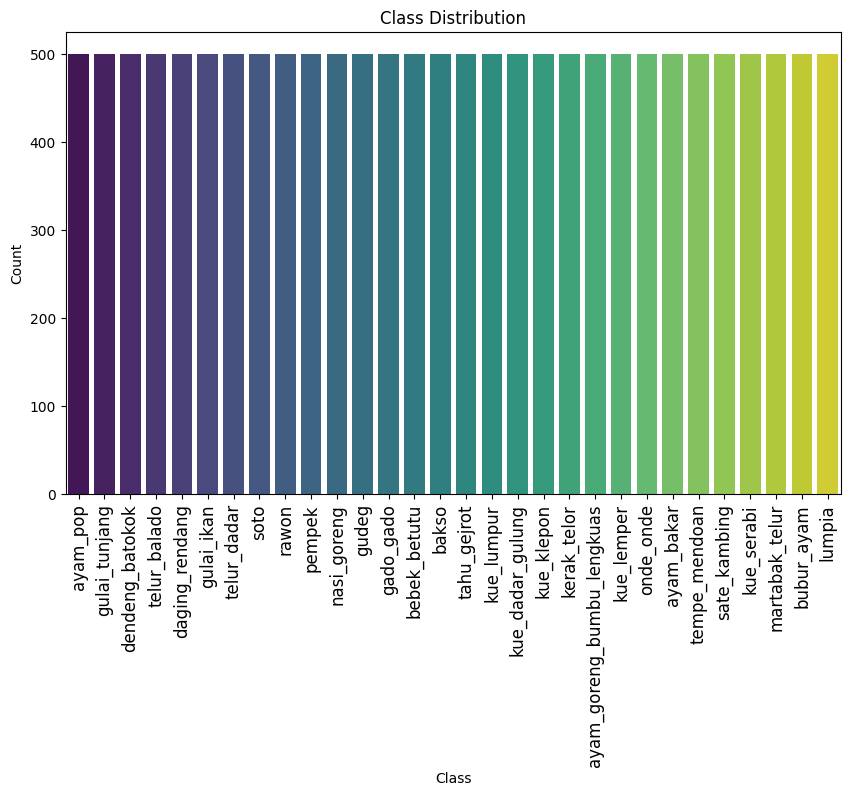

In [ ]:
class_distribution_80 = {}
for class_name in os.listdir(augmented_path_80):
  class_path = os.path.join(augmented_path_80, class_name)
  if os.path.isdir(class_path):
    num_images = len(os.listdir(class_path))
    class_distribution_80[class_name] = num_images

print("Class Distribution")

for class_name, count in class_distribution_80.items():
  print(f"{class_name}: {count}")

# Visualisasi
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_distribution_80.keys()), y=list(class_distribution_80.values()), palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Class', fontsize=10)
plt.xticks(rotation=90, fontsize=12)
plt.ylabel('Count', fontsize=10)
plt.show()

## Augmentasi dan generator data

In [ ]:
# Path ke folder hasil split

train_dir_80 = '/content/drive/MyDrive/Capstone Project/Dataset/dataset-split-80-10-10/train'
val_dir_80 = '/content/drive/MyDrive/Capstone Project/Dataset/dataset-split-80-10-10/val'
test_dir_80 = '/content/drive/MyDrive/Capstone Project/Dataset/dataset-split-80-10-10/test'

# Ukuran gambar dan batch
img_height, img_width = 244, 244
batch_size = 64

# Augmentasi hanya untuk training
train_datagen_80 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest'
)

# Validasi dan test hanya rescale
val_test_datagen_80 = ImageDataGenerator(rescale=1./255)

# Generator untuk training
train_generator_80 = train_datagen_80.flow_from_directory(
    train_dir_80,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)

# Generator untuk validation
validation_generator_80 = val_test_datagen_80.flow_from_directory(
    val_dir_80,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

# Generator untuk test
test_generator_80 = val_test_datagen_80.flow_from_directory(
    test_dir_80,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

# Jumlah gambar per subset
print("\nJumlah gambar per subset:")
print(f"- Training   : {train_generator_80.samples} gambar")
print(f"- Validation : {validation_generator_80.samples} gambar")
print(f"- Test       : {test_generator_80.samples} gambar")

# Distribusi kelas pada training
print("\n Jumlah gambar per kelas (Training):")
for class_name, class_idx in train_generator_80.class_indices.items():
    count = np.sum(train_generator_80.classes == class_idx)
    print(f"  - {class_name}: {count} gambar")

# Distribusi kelas pada validation
print("\n Jumlah gambar per kelas (Validation):")
for class_name, class_idx in validation_generator_80.class_indices.items():
    count = np.sum(validation_generator_80.classes == class_idx)
    print(f"  - {class_name}: {count} gambar")

# Distribusi kelas pada test
print("\n Jumlah gambar per kelas (Test):")
for class_name, class_idx in test_generator_80.class_indices.items():
    count = np.sum(test_generator_80.classes == class_idx)
    print(f"  - {class_name}: {count} gambar")

# Mapping class: index
print("\n Mapping Kelas dan Indeks:")
print(train_generator_80.class_indices)

Found 6903 images belonging to 30 classes.
Found 937 images belonging to 30 classes.
Found 957 images belonging to 30 classes.

Jumlah gambar per subset:
- Training   : 6903 gambar
- Validation : 937 gambar
- Test       : 957 gambar

 Jumlah gambar per kelas (Training):
  - ayam_bakar: 89 gambar
  - ayam_goreng_bumbu_lengkuas: 345 gambar
  - ayam_pop: 363 gambar
  - bakso: 356 gambar
  - bebek_betutu: 268 gambar
  - bubur_ayam: 226 gambar
  - daging_rendang: 403 gambar
  - dendeng_batokok: 215 gambar
  - gado_gado: 300 gambar
  - gudeg: 236 gambar
  - gulai_ikan: 217 gambar
  - gulai_tunjang: 396 gambar
  - kerak_telor: 112 gambar
  - kue_dadar_gulung: 125 gambar
  - kue_klepon: 91 gambar
  - kue_lemper: 53 gambar
  - kue_lumpur: 130 gambar
  - kue_serabi: 249 gambar
  - lumpia: 240 gambar
  - martabak_telur: 153 gambar
  - nasi_goreng: 400 gambar
  - onde_onde: 60 gambar
  - pempek: 327 gambar
  - rawon: 271 gambar
  - sate_kambing: 90 gambar
  - soto: 400 gambar
  - tahu_gejrot: 120 

## Modeling

### Pembobotan Model

In [ ]:
data_df = []

for dataset_type in ['train', 'test', 'val']:
  dataset_path = os.path.join(base_dir_80_20, dataset_type)

  if not os.path.isdir(dataset_path):
    continue

  for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)

    for image_name in os.listdir(class_path):
      if image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(class_path, image_name)
        data_df.append({
            'path' : image_path,
            'label' : class_name,
            'set' : dataset_type
        })

df_traditional_food = pd.DataFrame(data_df)

df_traditional_food['set'].value_counts()
df_traditional_food['label'].value_counts()

label
daging_rendang                504
soto                          500
nasi_goreng                   500
gulai_tunjang                 495
telur_balado                  489
ayam_pop                      454
bakso                         445
ayam_goreng_bumbu_lengkuas    432
pempek                        409
gado_gado                     376
rawon                         339
bebek_betutu                  335
kue_serabi                    312
lumpia                        300
gudeg                         295
bubur_ayam                    283
gulai_ikan                    272
dendeng_batokok               269
telur_dadar                   240
martabak_telur                193
kue_lumpur                    170
kue_dadar_gulung              165
tahu_gejrot                   160
kerak_telor                   152
kue_klepon                    131
sate_kambing                  130
ayam_bakar                    129
tempe_mendoan                 125
onde_onde                     100
kue_lemper                     93
Name: count, dtype: int64

In [ ]:
# menyesauaikan bobot
labels = df_traditional_food['label']

class_names = np.unique(labels)

class_weights_values = compute_class_weight(
    class_weight='balanced',
    classes=class_names,
    y=labels
)

class_weights = dict(zip(range(len(class_names)), class_weights_values))

# Cek hasilnya
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(2.27312661498708), 1: np.float64(0.6787808641975308), 2: np.float64(0.6458883994126284), 3: np.float64(0.6589513108614232), 4: np.float64(0.8753233830845771), 5: np.float64(1.0361601884570082), 6: np.float64(0.5818121693121693), 7: np.float64(1.090086741016109), 8: np.float64(0.7798758865248226), 9: np.float64(0.9940112994350282), 10: np.float64(1.0780637254901961), 11: np.float64(0.5923905723905724), 12: np.float64(1.9291666666666667), 13: np.float64(1.7771717171717172), 14: np.float64(2.2384223918575064), 15: np.float64(3.153046594982079), 16: np.float64(1.7249019607843137), 17: np.float64(0.9398504273504273), 18: np.float64(0.9774444444444444), 19: np.float64(1.5193436960276339), 20: np.float64(0.5864666666666667), 21: np.float64(2.9323333333333332), 22: np.float64(0.7169519152404238), 23: np.float64(0.8649950835791543), 24: np.float64(2.2556410256410255), 25: np.float64(0.5864666666666667), 26: np.float64(1.8327083333333334), 27: np.float64(0.599659168

### Pemanasan GPU

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout,GlobalAveragePooling2D

model = Sequential()

# Layer 1: Convolutional Layer with Batch Normalization
model.add(Conv2D(96, (11, 11), strides=(4, 4), input_shape=(224, 224, 3), padding='valid'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Layer 2: Convolutional Layer with Batch Normalization
model.add(Conv2D(256, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Layer 3: Convolutional Layer
model.add(Conv2D(384, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Layer 4: Convolutional Layer
model.add(Conv2D(384, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Layer 5: Convolutional Layer with Batch Normalization
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Flatten the output from previous layers
model.add(GlobalAveragePooling2D())

# Layer 6: Fully Connected Layer with Batch Normalization
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output Layer: Fully Connected Layer with 1000 neurons (for ImageNet)
# If you have a different number of classes, change the number of neurons in this layer accordingly.
model.add(Dense(30))

# You can replace the last layer with the appropriate number of output neurons for your specific classification task.

# Model Summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 54, 54, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 54, 54, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 26, 26, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 26, 26, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 12, 12, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             

 Total params: 4,046,622 (15.44 MB)

 Trainable params: 4,043,870 (15.43 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [ ]:
from tensorflow.keras.optimizers import Adam
from keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# --- Model Compilation ---
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), # Changed to CategoricalCrossentropy
    optimizer=Adam(learning_rate=0.01),
    metrics=['accuracy']
)

# --- Callbacks ---
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    min_lr=1e-5
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=7,
    verbose=1,
    mode="min",
    restore_best_weights=True,
)

checkpoint_path = '/content/drive/MyDrive/Capstone Project/Model/pemanasan_GPU.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)
os.makedirs(checkpoint_dir, exist_ok=True) # Ensure directory exists
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# --- Training the model ---
print("\n--- Starting Model Training ---")
history = model.fit(
    train_generator_80,
    epochs=2, # You might want to increase this for actual training
    validation_data=validation_generator_80,
    callbacks=[early_stop, checkpoint, reduce_lr]
)
print("--- Model Training Finished ---")

# --- Plotting Training History ---
sns.set_style("whitegrid")

def plot_metric(ax, data, label, color, linestyle):
    ax.plot(data, label=label, color=color, linestyle=linestyle)

def create_subplot(ax, title, ylabel, data, label, color, linestyle):
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    plot_metric(ax, data, label, color, linestyle)
    ax.legend()

def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    create_subplot(axes[0], 'Training and Validation Accuracy', 'Accuracy', history.history['accuracy'], 'Training Accuracy', 'b', '-')
    create_subplot(axes[0], 'Training and Validation Accuracy', 'Accuracy', history.history['val_accuracy'], 'Validation Accuracy', 'orange', '--')

    create_subplot(axes[1], 'Training and Validation Loss', 'Loss', history.history['loss'], 'Training Loss', 'b', '-')
    create_subplot(axes[1], 'Training and Validation Loss', 'Loss', history.history['val_loss'], 'Validation Loss', 'orange', '--')

    plt.tight_layout()

plot_history(history)
plt.show()

# --- Evaluation on Test Data ---
print("\n--- Evaluating Model on Test Data ---")
# Predict on the test data
y_pred_proba = model.predict(test_generator_80)
y_pred_labels = np.argmax(y_pred_proba, axis=1) # Get the index of the highest probability

# Get true labels from the generator
y_true = test_generator_80.classes

# Get class names from the generator's class_indices
class_names = list(test_generator_80.class_indices.keys())

# Calculate evaluation metrics
report = classification_report(y_true, y_pred_labels, target_names=class_names, digits=5)
conf_mat = confusion_matrix(y_true, y_pred_labels)

np.set_printoptions(precision=5)

print("\nClassification Report:")
print(report)
print("\nConfusion Matrix:")
print(conf_mat)

# --- Visualize Predictions on a Batch ---
print("\n--- Visualizing Sample Predictions ---")
# Load batch data
batch_images, batch_labels_one_hot = next(test_generator_80)
batch_labels = np.argmax(batch_labels_one_hot, axis=1) # Convert one-hot to class index

# Predict labels using the model
predicted_probabilities = model.predict(batch_images)
predicted_labels = np.argmax(predicted_probabilities, axis=1) # Get the index of the highest probability

# Define plot grid size
grid_size = (2, 4) # Adjust as needed based on batch size and desired visualization

# Create plot grid
fig, ax = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], figsize=(12, 6)) # Adjusted figsize for better viewing

# Loop over each subplot
for i, axi in enumerate(ax.flat):
    if i < len(batch_images): # Ensure we don't go out of bounds if batch_size is smaller than grid_size
        axi.imshow(batch_images[i])
        axi.set_title(f"True: {class_names[batch_labels[i]]}\nPredicted: {class_names[predicted_labels[i]]}")
        axi.axis("off")
    else:
        fig.delaxes(axi) # Delete empty subplots if batch size is smaller than grid

plt.tight_layout()
plt.show()

# --- Visualize the Confusion Matrix ---
print("\n--- Visualizing Confusion Matrix ---")
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


--- Starting Model Training ---
Epoch 1/2
 31/108 ━━━━━━━━━━━━━━━━━━━━ 35:48 28s/step - accuracy: 0.0468 - loss: 4.3985

### Buat Model DenseNet-201

In [ ]:
# Jumlah kelas
input_shape = (244, 244, 3)
num_classes = 30

# Load DenseNet201 tanpa top layer
base_model_dense_80 = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)
base_model_dense_80.trainable = True  # freeze

for layer in base_model_dense_80.layers[:-30]:
    layer.trainable = False

base_model_dense_80.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "densenet201"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 244, 244,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 250, 250,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 122, 122,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 122, 122,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 122, 122,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 124, 124,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 61, 61,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 61, 61,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 61, 61,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 61, 61,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 61, 61,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 61, 61,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 61, 61,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 61, 61,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 61, 61,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 61, 61,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 61, 61,    │     12,288 │ conv2_block2_0_r

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 1,109,120 (4.23 MB)

 Non-trainable params: 17,212,864 (65.66 MB)

In [ ]:
# Bangun model akhir
model_DenseNet201_80 = Sequential()
model_DenseNet201_80.add(base_model_dense_80)
model_DenseNet201_80.add(GlobalAveragePooling2D())

model_DenseNet201_80.add(Dense(128, activation='relu'))
model_DenseNet201_80.add(BatchNormalization())   # BatchNorm setelah ReLU
model_DenseNet201_80.add(Dropout(0.3))

model_DenseNet201_80.add(Dense(64, activation='relu'))
model_DenseNet201_80.add(BatchNormalization())   # BatchNorm lagi
model_DenseNet201_80.add(Dropout(0.2))

model_DenseNet201_80.add(Dense(30, activation='softmax'))  # Output 30 kelas

model_DenseNet201_80.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       245,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 30)             │         1,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,578,846 (70.87 MB)

 Trainable params: 1,365,598 (5.21 MB)

 Non-trainable params: 17,213,248 (65.66 MB)

In [ ]:
# Compile model dengan Adam dan LR 0.001
optimizer = Adam(learning_rate=0.001)
model_DenseNet201_80.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# EarlyStopping
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# ReduceLROnPlateau
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/Capstone Project/Model/densenet201_80.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# TensorBoard
tb = tf.keras.callbacks.TensorBoard(log_dir='tensorboard_logs')

### Training model..

In [ ]:
# training model
history_densenet201_80 = model_DenseNet201_80.fit(
    train_generator_80,
    epochs=25,
    validation_data=validation_generator_80,
    callbacks=[es, lr_scheduler, checkpoint, tb],
    steps_per_epoch=train_generator_80.samples // train_generator_80.batch_size,
    validation_steps=validation_generator_80.samples // validation_generator_80.batch_size,
    verbose=1,
    class_weight=class_weights
)

Epoch 1/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.2706 - loss: 2.6269 
Epoch 1: val_accuracy improved from -inf to 0.64955, saving model to /content/drive/MyDrive/Capstone Project/Model/densenet201_80.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 2398s 22s/step - accuracy: 0.2722 - loss: 2.6204 - val_accuracy: 0.6496 - val_loss: 1.1605 - learning_rate: 0.0010
Epoch 2/25
  1/107 ━━━━━━━━━━━━━━━━━━━━ 35s 332ms/step - accuracy: 0.7344 - loss: 1.0823
Epoch 2: val_accuracy did not improve from 0.64955
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 188ms/step - accuracy: 0.7344 - loss: 1.0823 - val_accuracy: 0.6484 - val_loss: 1.1574 - learning_rate: 0.0010
Epoch 3/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7513 - loss: 0.8852
Epoch 3: val_accuracy improved from 0.64955 to 0.82254, saving model to /content/drive/MyDrive/Capstone Project/Model/densenet201_80.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.7515 - loss: 0.8845 - val_accuracy: 0.8225 - val_loss: 0.6370 - learning_rate: 0.0010
Epoch 4/25
  1/107 ━━━━━━━━━━━━━━━━━━━━ 33s 315ms/step - accuracy: 0.8281 - loss: 0.5701
Epoch 4: val_accuracy improved from 0.82254 to 0.82478, saving model to /content/drive/MyDrive/Capstone Project/Model/densenet201_80.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.8281 - loss: 0.5701 - val_accuracy: 0.8248 - val_loss: 0.6404 - learning_rate: 0.0010
Epoch 5/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8423 - loss: 0.5397
Epoch 5: val_accuracy improved from 0.82478 to 0.85379, saving model to /content/drive/MyDrive/Capstone Project/Model/densenet201_80.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.8423 - loss: 0.5394 - val_accuracy: 0.8538 - val_loss: 0.5395 - learning_rate: 0.0010
Epoch 6/25
  1/107 ━━━━━━━━━━━━━━━━━━━━ 35s 334ms/step - accuracy: 0.8594 - loss: 0.4234
Epoch 6: val_accuracy improved from 0.85379 to 0.85491, saving model to /content/drive/MyDrive/Capstone Project/Model/densenet201_80.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 191ms/step - accuracy: 0.8594 - loss: 0.4234 - val_accuracy: 0.8549 - val_loss: 0.5421 - learning_rate: 0.0010
Epoch 7/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8920 - loss: 0.3747
Epoch 7: val_accuracy did not improve from 0.85491
107/107 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.8919 - loss: 0.3746 - val_accuracy: 0.8438 - val_loss: 0.5896 - learning_rate: 0.0010
Epoch 8/25
  1/107 ━━━━━━━━━━━━━━━━━━━━ 29s 275ms/step - accuracy: 0.8594 - loss: 0.3412
Epoch 8: val_accuracy did not improve from 0.85491
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.8594 - loss: 0.3412 - val_accuracy: 0.8404 - val_loss: 0.5887 - learning_rate: 0.0010
Epoch 9/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9242 - loss: 0.2574
Epoch 9: val_accuracy improved from 0.85491 to 0.87835, saving model to /content/drive/MyDrive/Capstone Project/Model/densenet201_80.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.9242 - loss: 0.2573 - val_accuracy: 0.8783 - val_loss: 0.4222 - learning_rate: 0.0010
Epoch 10/25
  1/107 ━━━━━━━━━━━━━━━━━━━━ 38s 363ms/step - accuracy: 0.9375 - loss: 0.2293
Epoch 10: val_accuracy improved from 0.87835 to 0.88170, saving model to /content/drive/MyDrive/Capstone Project/Model/densenet201_80.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 200ms/step - accuracy: 0.9375 - loss: 0.2293 - val_accuracy: 0.8817 - val_loss: 0.4208 - learning_rate: 0.0010
Epoch 11/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9516 - loss: 0.1718
Epoch 11: val_accuracy did not improve from 0.88170
107/107 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.9515 - loss: 0.1720 - val_accuracy: 0.8806 - val_loss: 0.3899 - learning_rate: 0.0010
Epoch 12/25
  1/107 ━━━━━━━━━━━━━━━━━━━━ 28s 273ms/step - accuracy: 0.9219 - loss: 0.2311
Epoch 12: val_accuracy improved from 0.88170 to 0.88616, saving model to /content/drive/MyDrive/Capstone Project/Model/densenet201_80.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.9219 - loss: 0.2311 - val_accuracy: 0.8862 - val_loss: 0.3842 - learning_rate: 0.0010
Epoch 13/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9605 - loss: 0.1417
Epoch 13: val_accuracy improved from 0.88616 to 0.89509, saving model to /content/drive/MyDrive/Capstone Project/Model/densenet201_80.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.9604 - loss: 0.1417 - val_accuracy: 0.8951 - val_loss: 0.3735 - learning_rate: 0.0010
Epoch 14/25
  1/107 ━━━━━━━━━━━━━━━━━━━━ 32s 303ms/step - accuracy: 0.9531 - loss: 0.1964
Epoch 14: val_accuracy improved from 0.89509 to 0.89732, saving model to /content/drive/MyDrive/Capstone Project/Model/densenet201_80.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.9531 - loss: 0.1964 - val_accuracy: 0.8973 - val_loss: 0.3673 - learning_rate: 0.0010
Epoch 15/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9685 - loss: 0.1087
Epoch 15: val_accuracy did not improve from 0.89732
107/107 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.9684 - loss: 0.1088 - val_accuracy: 0.8739 - val_loss: 0.4525 - learning_rate: 0.0010
Epoch 16/25
  1/107 ━━━━━━━━━━━━━━━━━━━━ 28s 273ms/step - accuracy: 0.9688 - loss: 0.0763
Epoch 16: val_accuracy did not improve from 0.89732
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.9688 - loss: 0.0763 - val_accuracy: 0.8783 - val_loss: 0.4479 - learning_rate: 0.0010
Epoch 17/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9681 - loss: 0.1037
Epoch 17: val_accuracy did not improve from 0.89732
107/107 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9680 - loss: 0.1037 - val_accuracy: 0.8828 - val_loss: 0.4148 - learning_rate: 0.0010
Epoch 18/25


107/107 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.9801 - loss: 0.0676 - val_accuracy: 0.9051 - val_loss: 0.3537 - learning_rate: 5.0000e-04
Epoch 22/25
  1/107 ━━━━━━━━━━━━━━━━━━━━ 33s 320ms/step - accuracy: 0.9844 - loss: 0.0501
Epoch 22: val_accuracy did not improve from 0.90513
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.9844 - loss: 0.0501 - val_accuracy: 0.9051 - val_loss: 0.3544 - learning_rate: 5.0000e-04
Epoch 23/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9896 - loss: 0.0410
Epoch 23: val_accuracy did not improve from 0.90513
107/107 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.9896 - loss: 0.0410 - val_accuracy: 0.9029 - val_loss: 0.3382 - learning_rate: 5.0000e-04
Epoch 24/25
  1/107 ━━━━━━━━━━━━━━━━━━━━ 28s 270ms/step - accuracy: 0.9844 - loss: 0.0268
Epoch 24: val_accuracy did not improve from 0.90513
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.9844 - loss: 0.0268 - val_accuracy: 0.9040 - val_loss: 0.3390 - learning_rate: 5.000

### Evaluasi Model

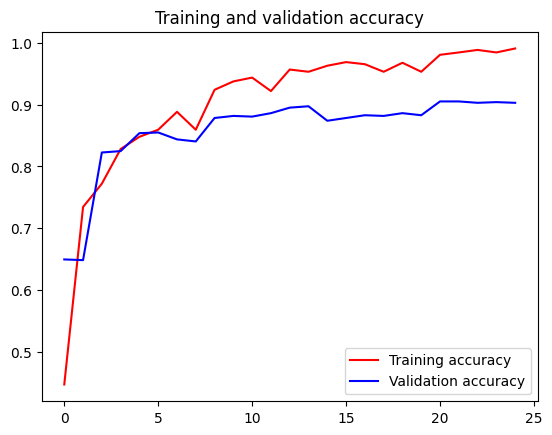

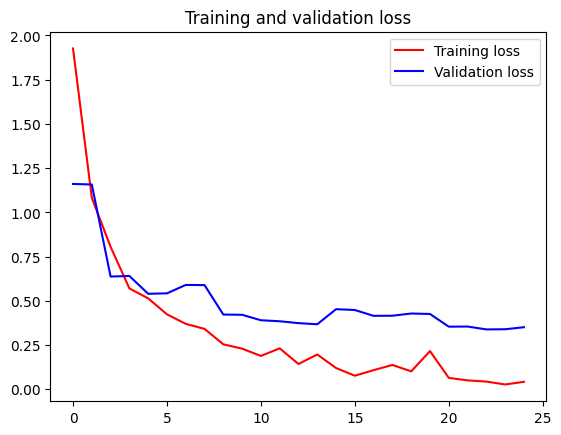

In [ ]:
acc = history_densenet201_80.history['accuracy']
val_acc = history_densenet201_80.history['val_accuracy']
loss = history_densenet201_80.history['loss']
val_loss = history_densenet201_80.history['val_loss']

epochs = range(len(acc))

plt.figure()
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:

# Evaluasi model menggunakan data pengujian
evaluation = model_DenseNet201_80.evaluate(
    test_generator_80,
    steps=test_generator_80.samples
)

# Menampilkan hasil evaluasi
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

957/957 ━━━━━━━━━━━━━━━━━━━━ 389s 407ms/step - accuracy: 0.9185 - loss: 0.2911 
Loss: 0.2912791073322296
Accuracy: 0.9184952974319458


In [ ]:
# Load model dari file .h5
model_path = "/content/drive/MyDrive/Capstone Project/Model/model_densenet201_80.h5"
model = tf.keras.models.load_model(model_path)

# Evaluasi model menggunakan data pengujian
evaluation = model.evaluate(
    test_generator_80,
    steps=test_generator_80.samples
    # test_generator_80,
    # steps=test_generator_80.samples // test_generator_80.batch_size,
    # verbose=1
)

# Menampilkan hasil evaluasi
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

957/957 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - accuracy: 0.9392 - loss: 0.2532
Loss: 0.25268664956092834
Accuracy: 0.939393937587738


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 434ms/step

Classification Report:
                            precision    recall  f1-score   support

                ayam_bakar       0.86      0.90      0.88        20
ayam_goreng_bumbu_lengkuas       0.84      0.93      0.88        44
                  ayam_pop       1.00      0.91      0.95        46
                     bakso       0.89      0.89      0.89        45
              bebek_betutu       0.93      0.74      0.82        34
                bubur_ayam       1.00      1.00      1.00        29
            daging_rendang       0.98      0.92      0.95        51
           dendeng_batokok       0.87      0.96      0.92        28
                 gado_gado       0.90      0.95      0.93        39
                     gudeg       0.78      0.97      0.87        30
                gulai_ikan       0.93      0.89      0.91        28
             gulai_tunjang       0.89      0.96      0.92        50
               kerak_telor       1.00      0.95   

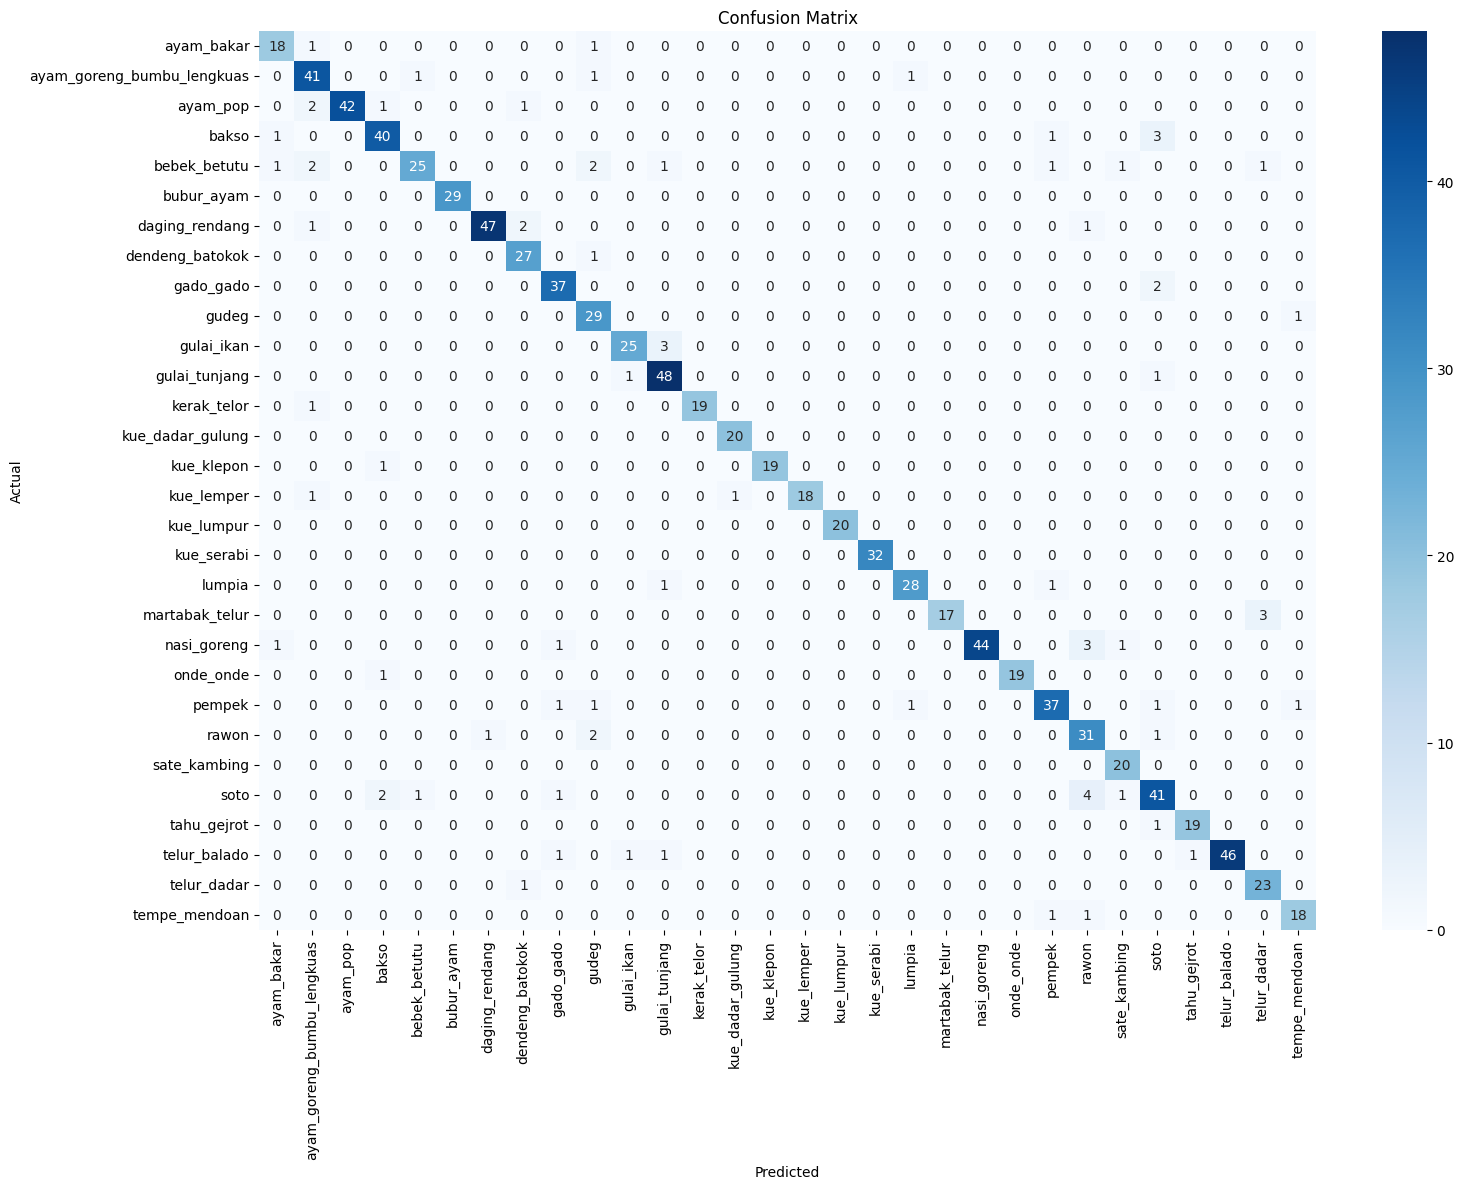

In [ ]:
# Prediksi label
Y_pred = model_DenseNet201_80.predict(test_generator_80, steps=len(test_generator_80), verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

# Ground truth
y_true = test_generator_80.classes

# Label kelas
class_labels = list(test_generator_80.class_indices.keys())

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(16, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step

Classification Report:
                            precision    recall  f1-score   support

                ayam_bakar       0.89      0.85      0.87        20
ayam_goreng_bumbu_lengkuas       0.97      0.86      0.92        44
                  ayam_pop       1.00      1.00      1.00        46
                     bakso       0.93      0.89      0.91        45
              bebek_betutu       0.90      0.82      0.86        34
                bubur_ayam       1.00      1.00      1.00        29
            daging_rendang       1.00      0.92      0.96        51
           dendeng_batokok       0.96      0.96      0.96        28
                 gado_gado       0.88      0.95      0.91        39
                     gudeg       0.91      0.97      0.94        30
                gulai_ikan       1.00      1.00      1.00        28
             gulai_tunjang       0.91      0.96      0.93        50
               kerak_telor       1.00      0.95     

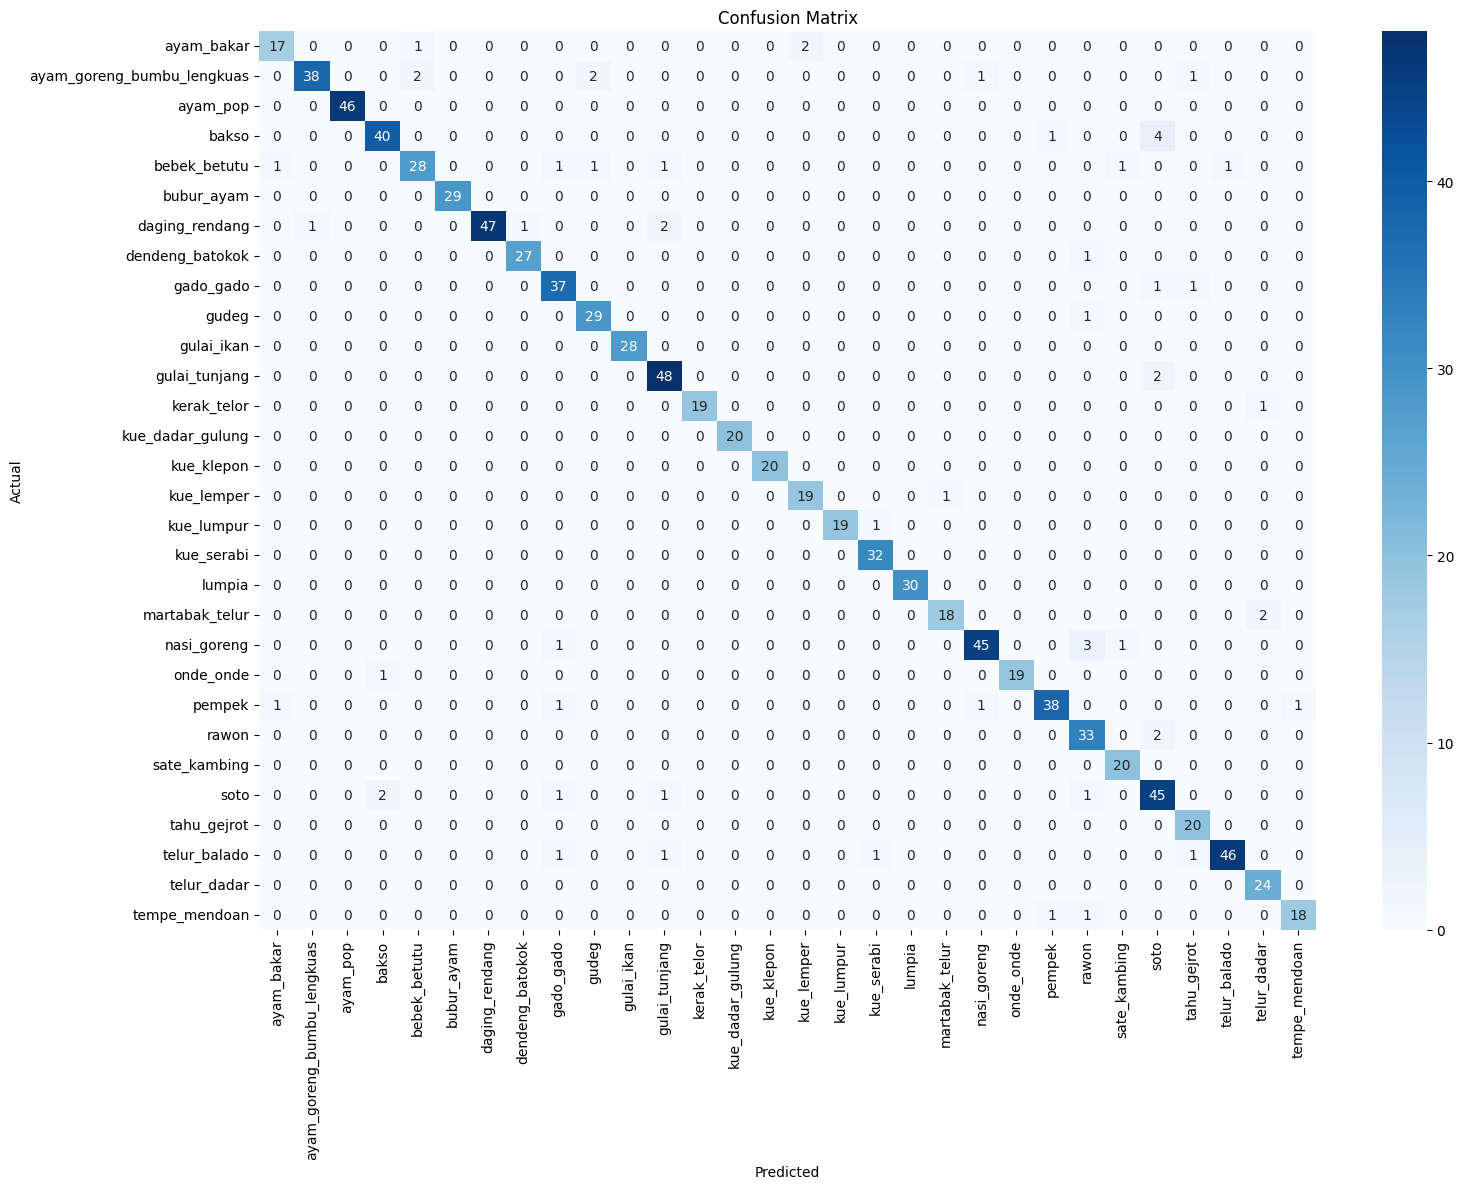

In [ ]:
# Load model dari file .h5
# Load model dari file .h5
model_path = "/content/drive/MyDrive/Capstone Project/Model/model_densenet201_80.h5"
model = tf.keras.models.load_model(model_path)

# Pastikan langkah prediksi berupa integer
steps = int(np.ceil(test_generator_80.samples / test_generator_80.batch_size))

# Prediksi label
Y_pred = model.predict(test_generator_80, steps=steps, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

# Ground truth
y_true = test_generator_80.classes

# Label kelas
class_labels = list(test_generator_80.class_indices.keys())

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(16, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## Konversi Model

In [ ]:
# Setup direktori penyimpanan
drive_model_path = "/content/drive/MyDrive/Capstone Project/Model"
os.makedirs(drive_model_path, exist_ok=True)

### Format SaveModel

In [ ]:
# Path model h5
h5_path = "/content/drive/MyDrive/Capstone Project/Model/model_densenet201_80.h5"

# Load model dari file .h5
model = tf.keras.models.load_model(h5_path)

# Simpan sebagai SavedModel
saved_model_dir = "/content/drive/MyDrive/Capstone Project/Model/saved_model_densenet201_80"
os.makedirs(saved_model_dir, exist_ok=True)
model.export(saved_model_dir)

# Verifikasi
assert os.path.exists(os.path.join(saved_model_dir, "saved_model.pb")), "Gagal menyimpan SavedModel"
print(f"✔ SavedModel berhasil disimpan di {saved_model_dir}")

Saved artifact at '/content/drive/MyDrive/Capstone Project/Model/saved_model_densenet201_80'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 30), dtype=tf.float32, name=None)
Captures:
  135167090712528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135167090712912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135167090713296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135167090713104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135167090704848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135167090714064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135167090714448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135167090712144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135167090713680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135167090715984: TensorSpe

### Konversi Format TFLite

In [ ]:
# Konversi ke TFLite
tflite_model_dir = "/content/drive/MyDrive/Capstone Project/Model/tflite_densenet201_80"
os.makedirs(tflite_model_dir, exist_ok=True)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Optional: optimisasi ukuran/kecepatan
tflite_model = converter.convert()

# Simpan model
tflite_path = os.path.join(tflite_model_dir, "model_densenet201_80.tflite")
with open(tflite_path, "wb") as f:
    f.write(tflite_model)

print(f"✔ Model berhasil dikonversi ke TFLite dan disimpan di {tflite_path}")

Saved artifact at '/tmp/tmp_yyk5t7u'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 30), dtype=tf.float32, name=None)
Captures:
  135167090712528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135167090712912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135167090713296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135167090713104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135167090704848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135167090714064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135167090714448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135167090712144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135167090713680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135167090715984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135167090716

### Format TFJS

In [ ]:
!pip install tensorflowjs --quiet
import tensorflowjs as tfjs

# Convert to TensorFlow.js
# Path TFJS output
tfjs_output_dir = "/content/drive/MyDrive/Capstone Project/Model/tfjs_densenet201_80"
os.makedirs(tfjs_output_dir, exist_ok=True)

# Konversi ke TFJS
tfjs.converters.convert_tf_saved_model(
    saved_model_dir,
    tfjs_output_dir
)

print(f"✔ Model berhasil dikonversi ke TFJS dan disimpan di {tfjs_output_dir}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


✔ Model berhasil dikonversi ke TFJS dan disimpan di /content/drive/MyDrive/Capstone Project/Model/tfjs_densenet201_80


# Inference Model

Saving ayam_pop (2).jpg to ayam_pop (2) (1).jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step

📊 Probabilitas Prediksi:
ayam_bakar                    : 0.0000
ayam_goreng_bumbu_lengkuas    : 0.0000
ayam_pop                      : 0.9999
bakso                         : 0.0000
bebek_betutu                  : 0.0000
bubur_ayam                    : 0.0000
daging_rendang                : 0.0000
dendeng_batokok               : 0.0000
gado_gado                     : 0.0000
gudeg                         : 0.0000
gulai_ikan                    : 0.0000
gulai_tunjang                 : 0.0000
kerak_telor                   : 0.0000
kue_dadar_gulung              : 0.0000
kue_klepon                    : 0.0000
kue_lemper                    : 0.0000
kue_lumpur                    : 0.0000
kue_serabi                    : 0.0000
lumpia                        : 0.0000
martabak_telur                : 0.0000
nasi_goreng                   : 0.0000
onde_onde                     : 0.0000
pempek                        : 0.0000
rawon                         : 0.0000


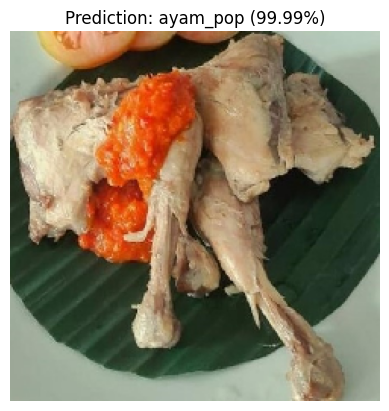

In [4]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from google.colab import files

# Upload gambar dari komputer
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Load model
model_path = '/content/drive/MyDrive/Capstone Project/Model/[FIX_93_ACC]_model_densenet201_80.h5'
model = load_model(model_path)

# Label (harus sesuai urutan training)
labels = sorted([
    'ayam_bakar', 'ayam_goreng_bumbu_lengkuas', 'ayam_pop', 'bakso', 'bebek_betutu',
    'bubur_ayam', 'daging_rendang', 'dendeng_batokok', 'gado_gado', 'gudeg',
    'gulai_ikan', 'gulai_tunjang', 'kerak_telor', 'kue_dadar_gulung', 'kue_klepon',
    'kue_lemper', 'kue_lumpur', 'kue_serabi', 'lumpia', 'martabak_telur',
    'nasi_goreng', 'onde_onde', 'pempek', 'rawon', 'sate',
    'soto', 'tahu_gejrot', 'telur_balado', 'telur_dadar', 'tempe_mendoan'
])

# Preprocessing gambar
img = image.load_img(image_path, target_size=(244, 244))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Prediksi
probs = model.predict(img_array)[0]

# Tampilkan hasil probabilitas
print("\n📊 Probabilitas Prediksi:")
for label, prob in zip(labels, probs):
    print(f"{label:<30}: {prob:.4f}")

# Threshold keyakinan minimum
threshold = 0.5
max_index = np.argmax(probs)
predicted_label = labels[max_index]
confidence = probs[max_index]

# Tentukan label akhir dan confidence
if confidence < threshold:
    final_prediction = f"Tidak Dikenali \n(Confidence: {confidence:.2%})"
else:
    final_prediction = f"{predicted_label} ({confidence:.2%})"

# Visualisasi hasil
plt.imshow(img)
plt.axis("off")
plt.title(f"Prediction: {final_prediction}", fontsize=12)
plt.show()